In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from fasttext.FastText import _FastText
import fasttext.util
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [6]:
data_original_train = pd.read_csv("urdu_data_train.csv")
data_original_test = pd.read_csv("urdu_data_test.csv")

In [7]:
data_original_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7393 entries, 0 to 7392
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   chunk_type      7393 non-null   object
 1   predicate       7393 non-null   object
 2   is_arg          7393 non-null   bool  
 3   role_label      7393 non-null   object
 4   head_word_root  7393 non-null   object
 5   head_word_pos   7393 non-null   object
 6   dependency      7393 non-null   object
dtypes: bool(1), object(6)
memory usage: 353.9+ KB


In [15]:
ft = fasttext.load_model('cc.ur.300.bin')

In [17]:
data_original_train.head()

,chunk_type,predicate,is_arg,role_label,head_word_root,head_word_pos,dependency
0,NP,اور,True,ARG2-LOC,لیبیا,n,k7
1,NP,اور,True,ARGM-PRX,پابندیاں,n,pof
2,VGF,اور,False,0,لگائی,v,ccof
3,NP,اور,True,ARGM-PRX,کارروائی,n,pof
4,VGF,اور,False,0,کی,v,ccof


In [20]:
label_encoders = {}
for column in data_original_train.columns:
        label_encoder = LabelEncoder()
        if column == 'role_label':
            data_to_encode = data_original_train[data_original_train['is_arg'].astype(str) != 'False']
            label_encoder.fit(data_to_encode[column].astype(str))
        else:
            label_encoder.fit(data_original_train[column].astype(str))
        label_encoders[column] = label_encoder
with open('label_encoders_svm.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
# Code to Load label encoders
# with open('label_encoders.pkl', 'rb') as f:
    # label_encoders = pickle.load(f)

In [28]:
def data_prep_df(df, label_encoders):
    df_copy = df.copy()
    # embeddings = []
    # for word in df_copy['head_word_root']:
    #     embeddings.append(ft.get_word_vector(word))
    # embedding_df = pd.DataFrame(embeddings, columns=[f'embedding_{i+1}' for i in range(300)])
    # df_copy.drop('head_word_root', axis=1, inplace=True)
    # for column in df_copy.columns:
        # print(column)
        # df_copy[column] = label_encoders[column].transform(df_copy[column].astype(str))
    # formatted_df = pd.concat([embedding_df, df_copy], ignore_index=True, axis=1, keys=['embedding_df', 'df_copy'])

    # formatted_df.columns = list(embedding_df.columns) + list(df_copy.columns)
    formatted_data = []
    columns = [column for column in df_copy if column!='head_word_root']
    embedding_columns = [f'embedding_{i+1}' for i in range(300)]
    columns = embedding_columns+columns
    for index, row in df_copy.iterrows():
        consider = True
        t = ft.get_word_vector(row['head_word_root']).tolist()
        for column, value in row.items():
            if column != 'head_word_root':
                try:
                    t += label_encoders[column].transform([str(value)]).tolist()
                except:
                    t += [len(label_encoders[column].classes_)]
                    
        formatted_data.append(t)
    formatted_df = pd.DataFrame(formatted_data, columns=columns)

    return formatted_df


In [29]:
formatted_df_train = data_prep_df(data_original_train.drop(['role_label'],axis=1), label_encoders)

# Binary Classification

In [30]:
# from sklearn.model_selection import train_test_split

# formatted_train_df, formatted_test_df = train_test_split(formatted_df, test_size=0.15, random_state=42)
formatted_train_df = data_prep_df(data_original_train.drop(['role_label'],axis=1), label_encoders)
formatted_test_df = data_prep_df(data_original_test.drop(['role_label'],axis=1), label_encoders)

columns_to_drop = ['is_arg']

binary_train_y = formatted_train_df['is_arg'].to_numpy()
binary_train_x = formatted_train_df.drop(columns_to_drop, axis=1).to_numpy()

binary_test_y = formatted_test_df['is_arg'].to_numpy()
binary_test_x = formatted_test_df.drop(columns_to_drop, axis=1).to_numpy()

In [31]:
binary_classifier = SVC(gamma='auto', decision_function_shape='ovo')
binary_classifier.fit(binary_train_x,binary_train_y)

SVC(decision_function_shape='ovo', gamma='auto')

In [32]:
preds = binary_classifier.predict(binary_test_x)

In [33]:
print(classification_report(binary_test_y, preds))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       843
           1       0.75      0.81      0.78       859

    accuracy                           0.77      1702
   macro avg       0.77      0.77      0.77      1702
weighted avg       0.77      0.77      0.77      1702



In [34]:
with open('binary_classifier.pkl', 'wb') as f:
    pickle.dump(binary_classifier, f)

# Argument Classifier

In [35]:
data_original_train.head()

,chunk_type,predicate,is_arg,role_label,head_word_root,head_word_pos,dependency
0,NP,اور,True,ARG2-LOC,لیبیا,n,k7
1,NP,اور,True,ARGM-PRX,پابندیاں,n,pof
2,VGF,اور,False,0,لگائی,v,ccof
3,NP,اور,True,ARGM-PRX,کارروائی,n,pof
4,VGF,اور,False,0,کی,v,ccof


In [36]:
arg_data_train = data_original_train[data_original_train['is_arg']==True]
arg_data_train = arg_data_train.drop(['is_arg'],axis=1)

arg_data_test = data_original_test[data_original_test['is_arg']==True]
arg_data_test = arg_data_test.drop(['is_arg'],axis=1)

# formatted_df = data_prep_df(arg_data, label_encoders)

In [37]:
# from sklearn.model_selection import train_test_split

# formatted_train_df, formatted_test_df = train_test_split(formatted_df, test_size=0.15, random_state=42)

formatted_train_df = data_prep_df(arg_data_train, label_encoders)
formatted_test_df = data_prep_df(arg_data_test, label_encoders)

columns_to_drop = ['role_label']

arg_train_y = formatted_train_df['role_label'].to_numpy()
arg_train_x = formatted_train_df.drop(columns_to_drop, axis=1).to_numpy()

arg_test_y = formatted_test_df['role_label'].to_numpy()
arg_test_x = formatted_test_df.drop(columns_to_drop, axis=1).to_numpy()

In [38]:
arg_test_x.shape

(859, 304)

In [39]:
arg_classifier = SVC(gamma='auto', decision_function_shape='ovo')
arg_classifier.fit(arg_train_x,arg_train_y)

SVC(decision_function_shape='ovo', gamma='auto')

In [40]:
arg_preds = arg_classifier.predict(arg_test_x)

In [41]:
accuracy_score(arg_test_y, arg_preds)

0.6833527357392316

In [42]:
print(classification_report(arg_test_y, arg_preds,zero_division=0.0))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72       120
           1       0.00      0.00      0.00         4
           2       0.75      0.86      0.80       245
           3       0.54      0.25      0.34        28
           4       0.95      0.45      0.61        40
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00        46
           7       0.00      0.00      0.00        26
           8       0.00      0.00      0.00         2
          10       0.52      0.70      0.60        37
          11       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         5
          15       0.47      0.89      0.61        76
          16       0.69      0.60      0.64        15
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         2
          19       0.28    

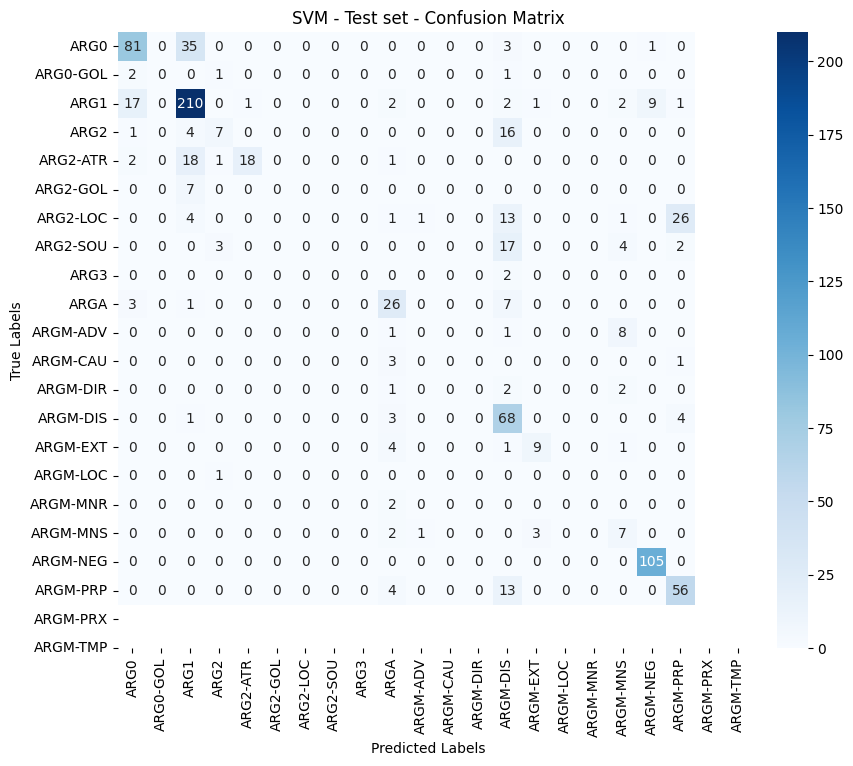

In [43]:
conf_matrix = confusion_matrix(arg_test_y, arg_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders["role_label"].classes_, yticklabels=label_encoders["role_label"].classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM - Test set - Confusion Matrix')
plt.savefig('svm_arg_cf.png')
plt.show()

In [46]:
formatted_train_df['role_label'].value_counts()

role_label
2     1042
20     464
0      458
15     377
21     258
4      218
10     175
6      131
3      102
19      75
16      74
7       70
11      35
1       25
12      15
13      15
8       14
5       14
17      13
14      12
18       7
9        1
Name: count, dtype: int64

In [47]:
with open('arg_classifier.pkl', 'wb') as f:
    pickle.dump(arg_classifier, f)